In [1]:
%matplotlib inline 
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import spearmanr

In [4]:
from access_biology_data import meta, relations, annotation, properties
from access_literature_data import medline
from access_science_shared import standardizer

import sys
sys.path.append('./../src/')
from aging_tools import inout, export, calculators
from access_aging_data import chaperome, earlier_studies, sequencing


In [5]:
import random

In [6]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

In [7]:
out_folder = '190407_visualize_mouse_models'
in_folder = '190406_predict_fold_change_mouse'

In [8]:
save_images = False
save_late_images = False

In [9]:
from narrative import nar181026_heat_confidence_genes

In [10]:
ref_genes = standardizer.reference_genes(10090, 'orp')  # only consider supported protein coding-genes

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [11]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 
pfus=[0]

In [12]:
all_de = all_de[
    (all_de['younger'] == 4) & 
    (all_de['is_detected'] == True) &
    (all_de['de_unit'] == 'both') &
    (all_de['tissue'].isin(tissues_to_consider)) &
    (all_de['pfu'].isin(pfus)) & 
    (all_de['gene_ncbi'].isin(ref_genes))
]
all_de['significant'] = all_de['padj'] < 0.05

In [13]:
sign = all_de[['condition', 'significant']].groupby('condition').agg(sum)

In [14]:
agg = []

for condition in all_de['condition'].unique():

    p = export.get_material_path(
        '{}/predictions_{}.csv'.format(in_folder, condition))
    if os.path.exists(p):
        agg.append(pd.read_csv(p))


df = pd.concat(agg).rename(columns={'Unnamed: 0': 'condition'}).set_index('condition')
df['mean'] = df.mean(1)
d = pd.merge(sign.reset_index(), df[['mean']].reset_index())
f = d['significant'] > 0
d.loc[f, 'log_significant'] = d.loc[f, 'significant'].apply(lambda x: np.log10(x))

In [15]:
zeros = sum(~f)

In [16]:
h = []
for j in range(zeros):
    h.append(-1 + random.randrange(0, 10)/20)
d.loc[~f, 'log_significant'] = h

In [17]:
f = d['condition'].str.contains('_0_4_[0-9]*$')
d = d[f]

In [18]:
d = pd.merge(d, all_de[['condition', 'younger', 'older']].drop_duplicates())

In [19]:
agg = []

for condition in all_de['condition'].unique():

    p = export.get_material_path(
        '{}/features_{}.csv'.format(in_folder, condition))

    if os.path.exists(p):
        h = pd.read_csv(p).set_index('feature')
        h = h.mean(1).to_frame('contribution').rename_axis('feature').reset_index()
        h.loc[:, 'condition'] = condition
        agg.append(h)



u = pd.concat(agg)

In [20]:
pi = u.pivot(index='condition', columns='feature', values='contribution')

In [21]:
pi.rank(1, ascending=False).loc[:, 'rna_full_SumACGT'].mean()

4.1911764705882355

In [22]:
(pi.rank(1, ascending=False).loc[:, 'rna_full_SumACGT'] == 1).sum()

27

In [23]:
is_first = pi.rank(1, ascending=False).loc[:, 'rna_full_SumACGT'] == 1
is_top_ten = pi.rank(1, ascending=False).loc[:, 'rna_full_SumACGT'].isin(range(2, 11))

In [24]:
is_not_top_ten = pi.rank(1, ascending=False).loc[:, 'rna_full_SumACGT']>10

In [25]:
is_first.sum()

27

In [26]:
is_top_ten.sum()

34

In [27]:
is_not_top_ten.sum()

7

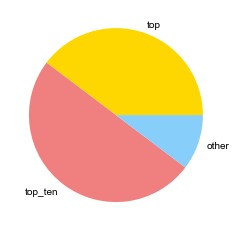

In [28]:
sizes = [is_first.sum(), is_top_ten.sum(), is_not_top_ten.sum()];
labels = ['top', 'top_ten', 'other'];
colors = ['gold', 'lightcoral', 'lightskyblue'];
 
plt.pie(sizes, labels=labels, colors=colors)


if save_images:
    export.export_image(
    '{}/pie.pdf'.format(out_folder))

In [29]:
d = d.set_index('condition')

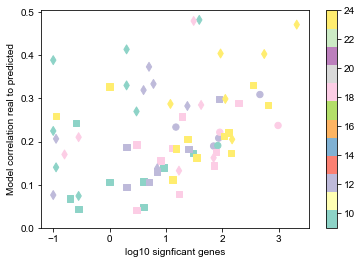

In [30]:
# plt.scatter(d.loc[~f, 'log_significant'], d.loc[~f, 'mean'], c=d.loc[~f, 'older'], s=40, cmap='viridis')

plt.scatter(
    d.loc[is_not_top_ten, 'log_significant'], 
    d.loc[is_not_top_ten, 'mean'], 
    c=d.loc[is_not_top_ten, 'older'], 
    s=40, 
    cmap='Set3',
    marker='o',
    vmin=9,
    vmax=24
)


plt.scatter(
    d.loc[is_top_ten, 'log_significant'], 
    d.loc[is_top_ten, 'mean'], 
    c=d.loc[is_top_ten, 'older'], 
    s=40, 
    cmap='Set3',
    marker='s',
    vmin=9,
    vmax=24
)

plt.scatter(
    d.loc[is_first, 'log_significant'], 
    d.loc[is_first, 'mean'], 
    c=d.loc[is_first, 'older'], 
    s=40, 
    cmap='Set3',
    marker='d',
    vmin=9,
    vmax=24
)

plt.xlabel('log10 signficant genes')
plt.ylabel('Model correlation real to predicted')
plt.colorbar()

plt.gca().set_ylim(bottom=0)

if save_images:
    export.export_image(
    '{}/prediction_accuracy.pdf'.format(out_folder))

In [31]:
is_first =  (pi.rank(1, ascending=False).loc[:, 'rna_full_SumACGT'] == 1) | \
            (pi.rank(1, ascending=False).loc[:, 'rna_cds_SumACGT'] == 1) | \
            (pi.rank(1, ascending=False).loc[:, 'gene_SumACGT'] == 1)

In [32]:
pi.shape

(68, 2236)

In [33]:
h = pd.merge(
    d.reset_index(), 
    pi.rank(
        1, ascending=False).loc[
        :, ['rna_full_SumACGT', 'rna_cds_SumACGT', 'gene_SumACGT']].min(
        1).to_frame('length_rank').rename_axis('condition').reset_index()
    

)

bins_of_interest = {
    '1-5': [1, 2, 3, 4, 5],
    '6-10': [6, 7, 8, 9, 10]
}

h.loc[:, 'bin'] =np.nan

for k in bins_of_interest.keys():
    f = h['length_rank'].isin(bins_of_interest[k])
    h.loc[f, 'bin'] = k

f = h['length_rank'] > 10
h.loc[f, 'bin'] = '11-{}'.format(int(pi.shape[1]))

g = h[['bin', 'mean']].groupby('bin')

to_visualize = pd.merge(   
    g.median().reset_index(),
    g.size().to_frame('comparisons').rename_axis('bin').reset_index()
).set_index('bin')

intended_order = [
    '1-5',
    '6-10',
    '11-{}'.format(int(pi.shape[1]))
]

to_visualize = to_visualize.loc[intended_order, :].reset_index()

In [34]:
to_visualize

,bin,mean,comparisons
0,1-5,0.205216,63
1,6-10,0.213124,1
2,11-2236,0.214935,4


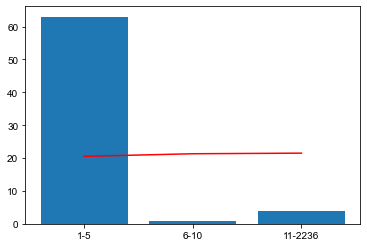

In [35]:
height = to_visualize.loc[:, 'comparisons']
bars = to_visualize.loc[:, 'bin']
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)



height = to_visualize.loc[:, 'mean']

plt.plot(y_pos, height*100, 'r')

save_late_images = True

if save_late_images:
    export.export_image(
    '{}/fraction_of_experiments.pdf'.format(out_folder))

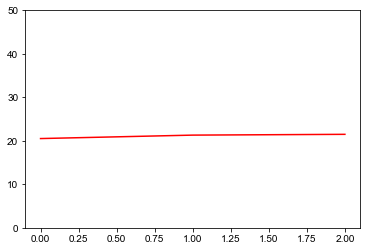

In [36]:
save_late_images = True

plt.plot(y_pos, height*100, 'r')

plt.ylim(0, 50)
# plt.gca().set_ylim(bottom=0)

if save_late_images:
    export.export_image(
    '{}/red_line_for_helper_axis.pdf'.format(out_folder))



In [37]:
to_visualize.sort_values('bin')

,bin,mean,comparisons
0,1-5,0.205216,63
2,11-2236,0.214935,4
1,6-10,0.213124,1


In [38]:
d

,significant,mean,log_significant,younger,older
condition,,,,,
Adrenal_0_4_12,464.0,0.309188,2.666518,4.0,12.0
Adrenal_0_4_18,974.0,0.237433,2.988559,4.0,18.0
Adrenal_0_4_24,647.0,0.285258,2.810904,4.0,24.0
Adrenal_0_4_9,30.0,0.174306,1.477121,4.0,9.0
BAT_0_4_12,70.0,0.189746,1.845098,4.0,12.0
...,...,...,...,...,...
Stomach_0_4_9,3.0,0.269998,0.477121,4.0,9.0
WAT_0_4_12,86.0,0.208119,1.934498,4.0,12.0
WAT_0_4_18,90.0,0.221752,1.954243,4.0,18.0


In [39]:
is_first

condition
Adrenal_0_4_12    False
Adrenal_0_4_18    False
Adrenal_0_4_24    False
Adrenal_0_4_9     False
BAT_0_4_12        False
                  ...  
Stomach_0_4_9      True
WAT_0_4_12        False
WAT_0_4_18        False
WAT_0_4_24        False
WAT_0_4_9         False
Length: 68, dtype: bool

In [40]:
d.loc[is_first, 'perf'] = 'top'
d.loc[is_top_ten, 'perf'] = 'top ten'
d.loc[is_not_top_ten, 'perf'] = 'not top ten'

In [41]:
d.loc[is_first, 'perf'] = 'top'
d.loc[~is_first, 'perf'] = 'other'
# d.loc[is_top_ten, 'perf'] = 'top ten'
# d.loc[is_not_top_ten, 'perf'] = 'not top ten'

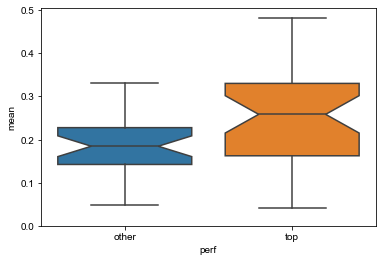

In [42]:
g = sns.boxplot(
    x='perf', 
    y='mean', 
    data=d, 
    notch=True,
    order=['other', 'top']
)

g.set(ylim=(0, None))


if save_images:
    export.export_image(
    '{}/boxplot_two.pdf'.format(out_folder))

In [43]:
from scipy.stats import mannwhitneyu

In [44]:
mannwhitneyu(
    d[d['perf']=='other']['mean'],
    d[d['perf']=='top']['mean'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=415.0, pvalue=0.05170932481462026)

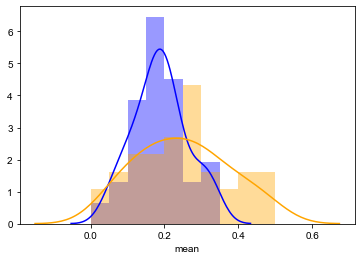

In [45]:
v = np.arange(0, 0.7, 0.05)

sns.distplot(
    d.loc[~is_first, 'mean'],
    bins=v,
    color='blue'

)

sns.distplot(
    d.loc[is_first, 'mean'],
    bins=v,
    color='orange'
)

d.loc[~is_first, 'perf'] = 'other'
d.loc[is_first, 'perf'] = 'top'

if save_images:
    export.export_image(
    '{}/histogram_two.pdf'.format(out_folder))

In [46]:
d['perf'].value_counts()

top      37
other    31
Name: perf, dtype: int64

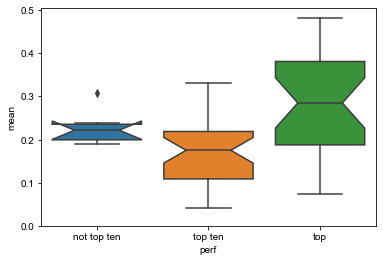

In [47]:
d.loc[is_first, 'perf'] = 'top'
d.loc[is_top_ten, 'perf'] = 'top ten'
d.loc[is_not_top_ten, 'perf'] = 'not top ten'

g = sns.boxplot(
    x='perf', 
    y='mean', 
    data=d, 
    notch=True,
    order=[
        'not top ten',
        'top ten',
        'top'
    ]
)


g.set(ylim=(0, None))

if save_images:
    export.export_image(
    '{}/boxplot_three.pdf'.format(out_folder))

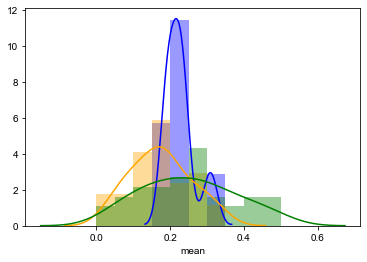

In [48]:
v = np.arange(0, 0.7, 0.05)

sns.distplot(
    d.loc[is_not_top_ten, 'mean'],
    bins=v,
    color='blue'

)

sns.distplot(
    d.loc[is_top_ten, 'mean'],
    bins=v,
    color='orange'
)


sns.distplot(
    d.loc[is_first, 'mean'],
    bins=v,
    color='green'
)

d.loc[~is_first, 'perf'] = 'other'
d.loc[is_first, 'perf'] = 'top'

if save_images:
    export.export_image(
    '{}/histogram_three.pdf'.format(out_folder))

In [49]:
is_first =  (pi.rank(1, ascending=False).loc[:, 'rna_full_SumACGT'] == 1) | \
            (pi.rank(1, ascending=False).loc[:, 'rna_cds_SumACGT'] == 1) | \
            (pi.rank(1, ascending=False).loc[:, 'gene_SumACGT'] == 1)


In [50]:
d.loc[is_first, 'perf'] = 'top'
d.loc[~is_first, 'perf'] = 'other'

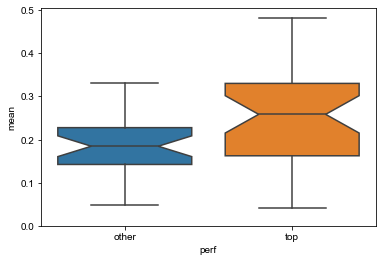

In [51]:
g = sns.boxplot(
    x='perf', 
    y='mean', 
    data=d, 
    notch=True,
    order=['other', 'top']
)

g.set(ylim=(0, None))


if save_images:
    export.export_image(
    '{}/boxplot_two_all_length.pdf'.format(out_folder))

In [52]:
d['perf'].value_counts()

top      37
other    31
Name: perf, dtype: int64

In [53]:
mannwhitneyu(
    d[d['perf']=='other']['mean'],
    d[d['perf']=='top']['mean'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=415.0, pvalue=0.05170932481462026)

In [54]:
d.head()

,significant,mean,log_significant,younger,older,perf
condition,,,,,,
Adrenal_0_4_12,464.0,0.309188,2.666518,4.0,12.0,other
Adrenal_0_4_18,974.0,0.237433,2.988559,4.0,18.0,other
Adrenal_0_4_24,647.0,0.285258,2.810904,4.0,24.0,other
Adrenal_0_4_9,30.0,0.174306,1.477121,4.0,9.0,other
BAT_0_4_12,70.0,0.189746,1.845098,4.0,12.0,other


In [55]:
helper = pd.merge(
    d.reset_index()[['condition', 'mean']],
    all_de[['condition', 'tissue', 'older']].drop_duplicates()
).pivot(index='tissue', columns='older', values='mean')

In [56]:

if save_late_images:
    export.export_full_frame(
        '{}/table.csv'.format(out_folder),
        helper
    )

In [57]:
def nice_plot(h):
    t = h.copy()
    
    tissue_dict = {
        'Adrenal': 'Adrenal gland',
        'BAT': 'Brown adipose tissue',
        'Blood': 'Blood',
        'Brain': 'Frontal cortex',
        'Cerebellum': 'Cerebellum',
        'Esophagus': 'Esophagus',
        'GutEP': 'Gut epithelium',
        'Heart': 'Heart',
        'Kidney': 'Kidney',
        'LI': 'Large intestine',
        'Liver': 'Liver',
        'Lung': 'Lung',
        'MuscSat': 'Muscle',
        'SI': 'Small intestine',
        'Skin': 'Skin',
        'Stomach': 'Stomach',
        'WAT': 'White adipose tissue'
    }
    
    t = t.rename(index=tissue_dict)
    t = t.sort_index()
    
    plt.figure(figsize=(4, 5))


    sns.heatmap(
        t, 
        cmap='YlOrBr', 
        annot=True,
        vmin=0,
        vmax=0.5
    )

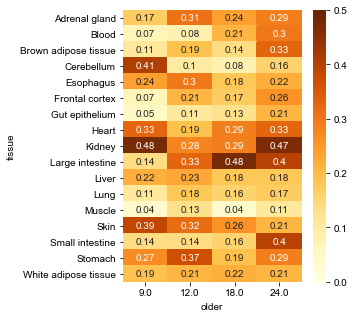

In [58]:
nice_plot(helper.apply(lambda x: np.round(x, 2)))


if save_images:
    export.export_image(
    '{}/table_nice.pdf'.format(out_folder))

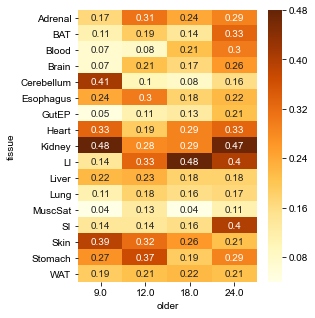

In [59]:
plt.figure(figsize=(4, 5))



sns.heatmap(
    helper.apply(lambda x: np.round(x, 2)),
    cmap='YlOrBr', 
    annot=True)


if save_images:
    export.export_image(
    '{}/table.pdf'.format(out_folder))

In [60]:
d['older'].value_counts()

9.0     17
24.0    17
18.0    17
12.0    17
Name: older, dtype: int64

In [61]:
spearmanr(d.loc[:, 'significant'], d.loc[:, 'mean'])

SpearmanrResult(correlation=0.3416302227771083, pvalue=0.004354763895555325)

In [62]:
if save_images:
    export.export_full_frame(
        '{}/mean_prediction.xlsx'.format(out_folder),
    d.drop('log_significant', 1),
    )

In [63]:
d[d['significant']==0].sort_values('mean', ascending=False)

,significant,mean,log_significant,younger,older,perf
condition,,,,,,
Skin_0_4_9,0.0,0.388931,-1.00,4.0,9.0,top
Brain_0_4_24,0.0,0.259219,-0.95,4.0,24.0,top
Esophagus_0_4_9,0.0,0.243449,-0.60,4.0,9.0,other
Liver_0_4_9,0.0,0.224692,-1.00,4.0,9.0,top
Blood_0_4_18,0.0,0.210225,-0.55,4.0,18.0,top
Brain_0_4_12,0.0,0.206525,-0.95,4.0,12.0,top
Brain_0_4_18,0.0,0.170167,-0.80,4.0,18.0,top
SI_0_4_9,0.0,0.140286,-0.95,4.0,9.0,top
Blood_0_4_12,0.0,0.076015,-1.00,4.0,12.0,top


In [64]:
d.sort_values('mean', ascending=False)

,significant,mean,log_significant,younger,older,perf
condition,,,,,,
Kidney_0_4_9,39.0,0.482377,1.591065,4.0,9.0,top
LI_0_4_18,31.0,0.479915,1.491362,4.0,18.0,top
Kidney_0_4_24,2089.0,0.471329,3.319938,4.0,24.0,top
Cerebellum_0_4_9,2.0,0.413945,0.301030,4.0,9.0,top
LI_0_4_24,93.0,0.404364,1.968483,4.0,24.0,top
...,...,...,...,...,...,...
Brain_0_4_9,0.0,0.073859,-0.550000,4.0,9.0,top
Blood_0_4_9,0.0,0.068164,-0.700000,4.0,9.0,other
GutEP_0_4_9,4.0,0.048424,0.602060,4.0,9.0,other


In [65]:
def z(x):
    return (x - np.mean(x)) / np.std(x)

In [66]:
piz = pi.apply(lambda x: z(x), 1)

In [67]:
piz = piz.loc[:, piz.isnull().sum() == 0]

In [68]:
collected_importance = pi.mean().to_frame('mean importance')

In [69]:
collected_importance = collected_importance.sort_values(
    'mean importance', 
    ascending=False)

In [70]:
collected_importance.loc[:, 'cumulative'] = collected_importance['mean importance'].cumsum()

In [71]:
if save_images:
    export.export_full_frame(
        '{}/collected_importance.xlsx'.format(out_folder),
    collected_importance)

In [72]:
collected_importance

,mean importance,cumulative
feature,,
rna_full_SumACGT,0.115398,0.115398
tf_different_tfs,0.068774,0.184172
rna_cds_SumACGT,0.057348,0.241520
gene_SumACGT,0.048269,0.289789
rna_full_CG,0.040648,0.330437
...,...,...
tf_Elk3,0.000000,1.000000
miRNA_miR-6392-5p,0.000000,1.000000
tf_Ddit3,0.000000,1.000000


In [73]:
pi.mean().sort_values(ascending=False).cumsum()

feature
rna_full_SumACGT     0.115398
tf_different_tfs     0.184172
rna_cds_SumACGT      0.241520
gene_SumACGT         0.289789
rna_full_CG          0.330437
                       ...   
miRNA_miR-467d-5p    1.000000
tf_Ddit3             1.000000
miRNA_miR-6968-3p    1.000000
miRNA_miR-466h-3p    1.000000
miRNA_miR-375-5p     1.000000
Length: 2236, dtype: float64

In [74]:
x = pi.transpose().rank(ascending=False)

In [75]:
if save_images:
    export.export_full_frame(
        '{}/ranks.xlsx'.format(out_folder),
    x)

In [76]:
x.median(1).sort_values()

feature
rna_full_SumACGT        2.50
tf_different_tfs        3.00
gene_SumACGT            4.00
rna_cds_SumACGT         5.00
rna_full_CG             7.00
                      ...   
miRNA_miR-7236-3p    1446.25
miRNA_miR-467d-5p    1446.25
miRNA_miR-8090       1446.25
miRNA_miR-6968-3p    1446.25
tf_Nr1h2             1446.25
Length: 2236, dtype: float64

In [77]:
x.columns = [y.replace('_0_', '_') for y in x.columns]

<Figure size 1440x1440 with 0 Axes>

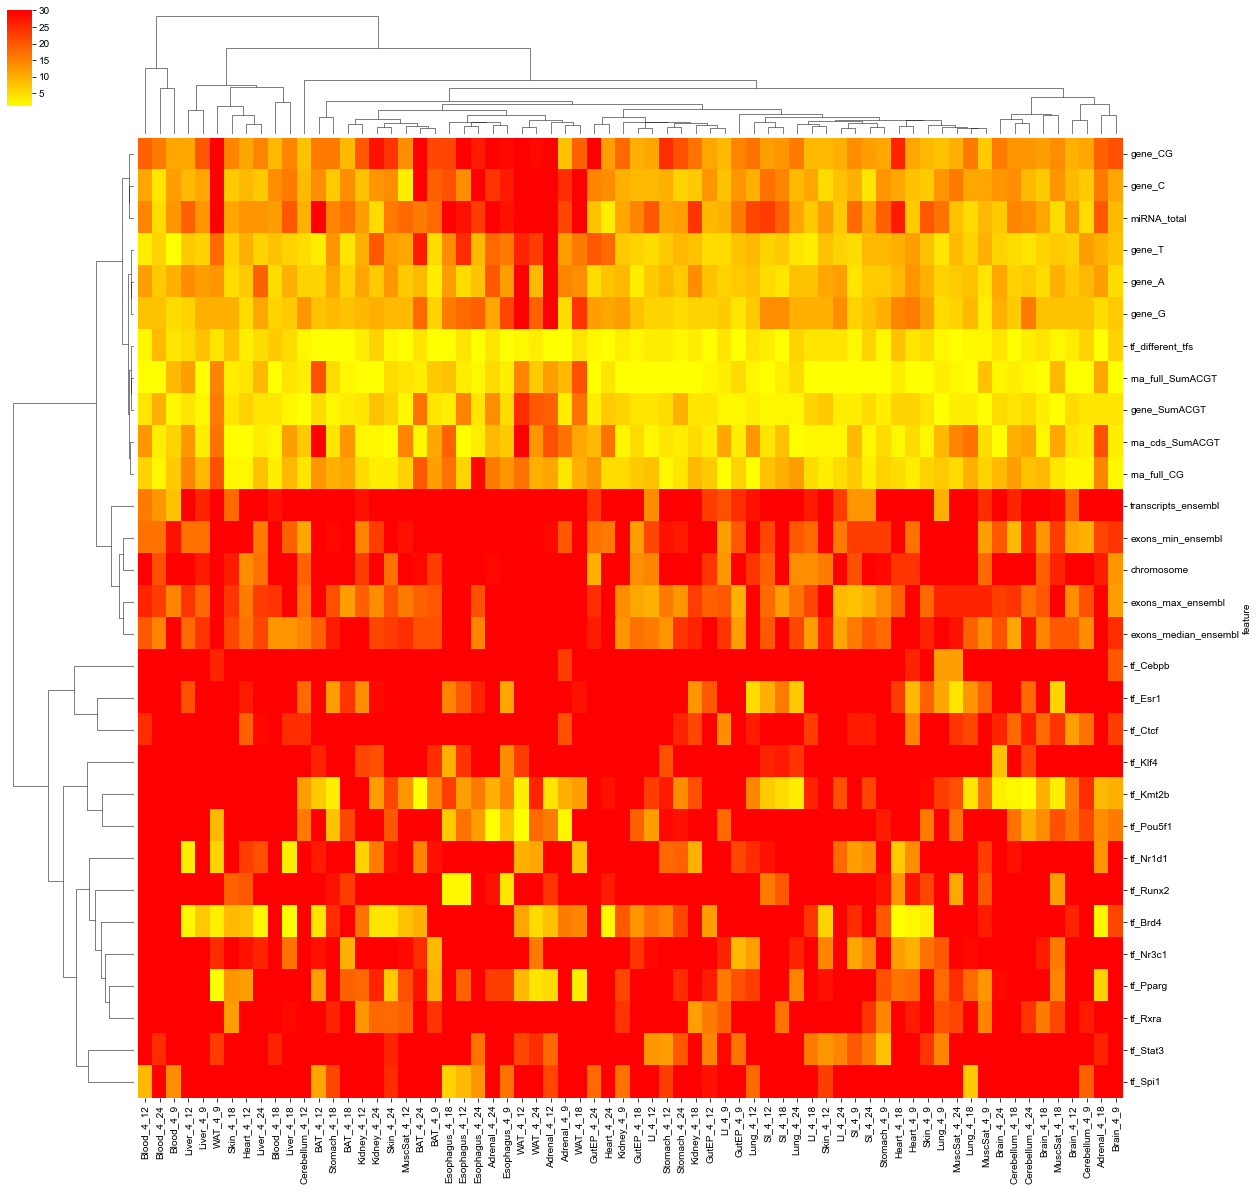

In [78]:
plt.figure(figsize=(20, 20))

sns.clustermap(
    x.loc[x.median(1).sort_values().index[:30], :], 
    vmin=1, 
    vmax=30, 
    cmap='autumn_r', 
    method='ward',
    figsize=(20, 20)
)


if save_images:
    export.export_image(
        '{}/autumn_to_30.pdf'.format(out_folder))

In [79]:
y = x.copy()

In [80]:
renamer={
    'Adrenal': 'Adrenal gland',
    'BAT': 'Brown adipose tissue',
    'Blood': 'Blood',
    'Brain': 'Frontal cortex',
    'Cerebellum': 'Cerebellum',
    'Esophagus': 'Esophagus',
    'GutEP': 'Gut epithelium',
    'Heart': 'Heart',
    'Kidney': 'Kidney',
    'LI': 'Large intestine',
    'Liver': 'Liver',
    'Lung': 'Lung',
    'MuscSat': 'Muscle',
    'SI': 'Small intestine',
    'Skin': 'Skin',
    'Stomach': 'Stomach',
    'WAT': 'White adipose tissue'      
    }

In [81]:
for k, v in renamer.items():
    y.columns = [x.replace(k, v) for x in y.columns]

In [82]:
y.columns = [x.replace('_4_', ' ') for x in y.columns]

In [83]:
import natsort

In [84]:
y = y.loc[:, natsort.natsorted(y.columns)]

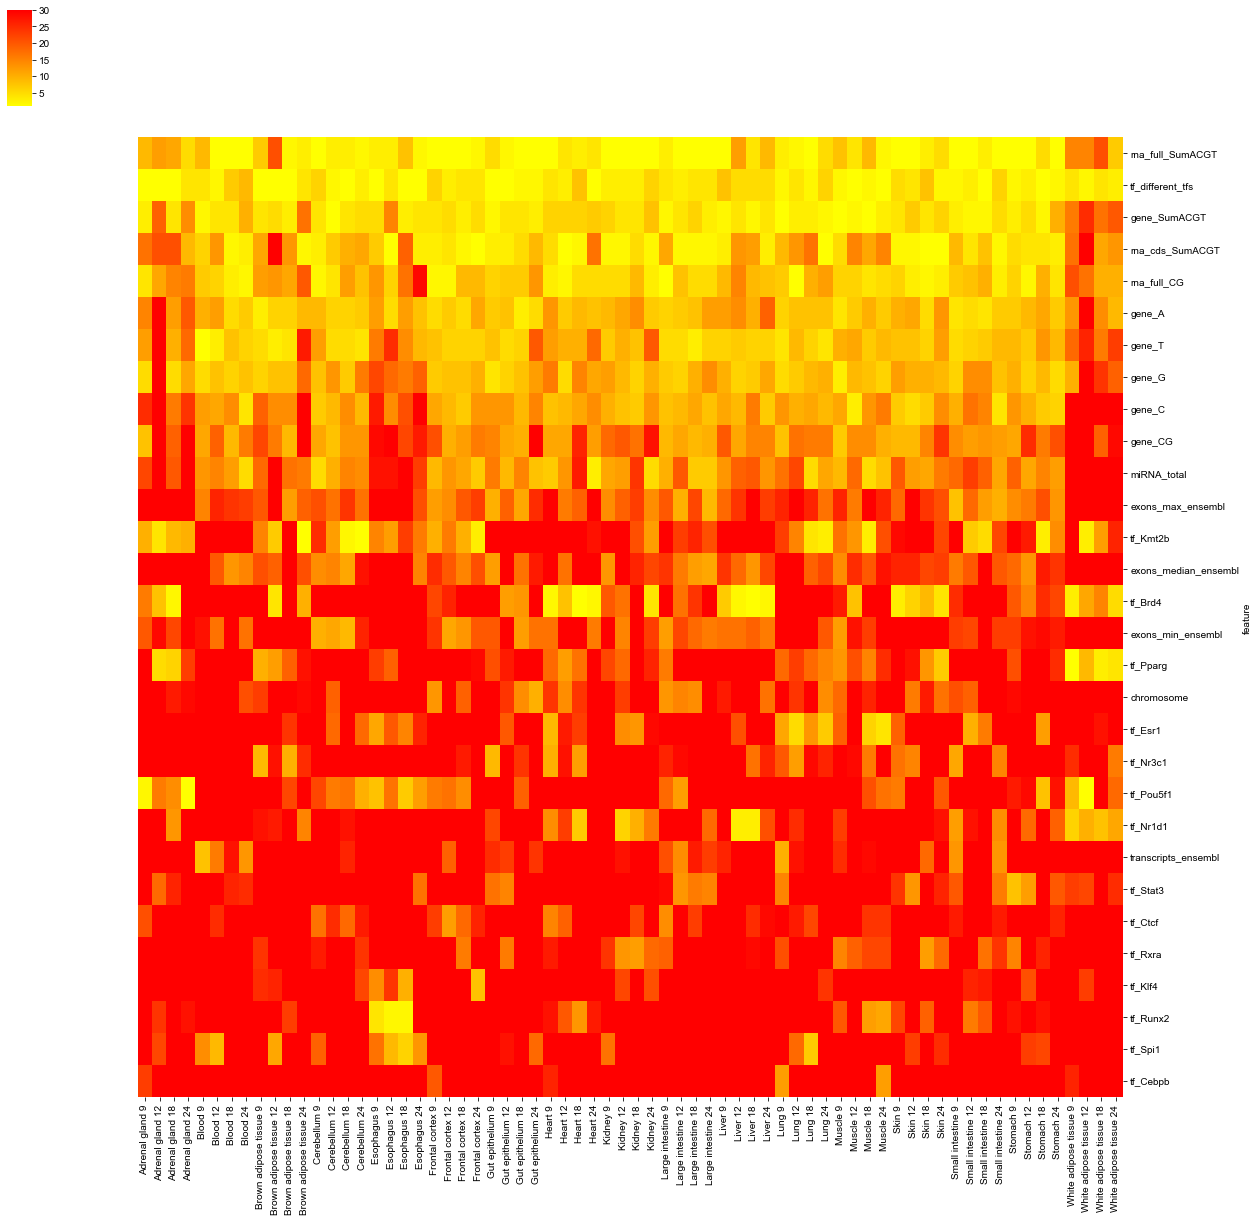

In [85]:
sns.clustermap(
    y.loc[y.median(1).sort_values().index[:30], :], 
    vmin=1, 
    vmax=30, 
    cmap='autumn_r', 
    method='ward',
    figsize=(20, 20),
    row_cluster=False,
    col_cluster=False
)

if save_late_images:
    
    export.export_image(
        '{}/autumn_to_30_rank_sorted.pdf'.format(out_folder))